LSTM

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def get_time(filename):
    values = filename.split("_")
    for t_value in values:
        if t_value in ['2','4','6','8','10','12']:
            # print(t_value)
            return int(t_value)
    return None

In [3]:
features_col = ['Arflux1','Arflux2','Arflux3','Arflux4','Arflux5','Arflux6',
            'Fflux1','Fflux2','Fflux3','Fflux4','Fflux5','Fflux6',
            'ArExponent','FrExponent',
            'yield_at_zero1','yield_at_zero2','yield_at_zero3',
            'yield_max1','yield_max2','yield_max3',
            'theta_max1','theta_max2','theta_max3','mizk',
            'p1','p2','p3','p4','p5']

In [4]:
df_final = pd.DataFrame()

test_df_final = pd.DataFrame()

test_file_num = 0
turn = 0

for folder in os.listdir('C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles'):
    input_values = folder.split('_')[1:]
    input_values = [float(item) for item in input_values]

    if(turn==1): test_file_num+=6

    # sorting file acc to len so that t= 10,12 gets to its original pos
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}'), key=len):

        if(turn==0 or test_file_num>=300):
            df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = df[df['FitRadius_Avg']==0].index
            df = df.drop(zero_values_row_index)
            indexes_of_not_silicon = df[df['Z']>=0.000].index
            df = df.drop(indexes_of_not_silicon)

            new_df = pd.DataFrame()

            new_df['Z'] = df['Z'][::2]
            new_df['avg fitradius'] = df['FitRadius_Avg'][::2]
            new_df['time'] = get_time(file)

            for i in range(29):
                # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            df_final = pd.concat([df_final,new_df])    

        else: 

            test_df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = test_df[test_df['FitRadius_Avg']==0].index
            test_df = test_df.drop(zero_values_row_index)
            indexes_of_not_silicon = test_df[test_df['Z']>=0.000].index
            test_df = test_df.drop(indexes_of_not_silicon)


        #just for getting depth
            new_df = pd.DataFrame()

            new_df['Z'] = test_df['Z'].iloc[::2]
            new_df['avg fitradius'] = test_df['FitRadius_Avg'][::2]
            new_df['time'] = get_time(file)

            for i in range(29):
                new_df[features_col[i]] = input_values[i]
            test_df_final = pd.concat([test_df_final,new_df])   
    turn = 1 - turn 

In [5]:
test_df_final.shape

(15908, 32)

C:\Users\jayra\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\jayra\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


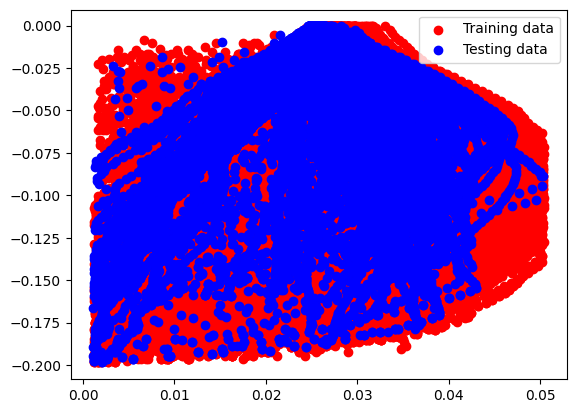

In [6]:
plt.scatter(df_final['avg fitradius'],df_final['Z'], c='red', label='Training data')
plt.scatter(test_df_final['avg fitradius'],test_df_final['Z'], c='blue', label='Testing data')
plt.legend()

In [7]:
x_train = df_final.loc[:, ~df_final.columns.isin(['avg fitradius'])]
y_train = df_final[['avg fitradius']]
y_test = test_df_final[['avg fitradius']]
x_test = test_df_final.drop(['avg fitradius'], axis=1)

In [8]:
y_train_s = y_train*100000000
y_test_s = y_test*100000000

In [12]:
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
X_scale_arr = scaler_x_train.fit_transform(x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)

# scaler_y_train = StandardScaler()
# y_scale_arr = scaler_y_train.fit_transform(y_train)
# df_scaledy = pd.DataFrame(y_scale_arr, columns=y_train.columns)

scaler_x_test = StandardScaler()
X_scale_t_arr = scaler_x_test.fit_transform(x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

# scaler_y_test = StandardScaler()
# y_scale_t_arr = scaler_y_test.fit_transform(y_test)
# df_scaledy_t = pd.DataFrame(y_scale_t_arr, columns=y_test.columns)




X_train_scaled_reshaped = X_scale_arr.reshape(X_scale_arr.shape[0],1,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(X_scale_t_arr.shape[0],1,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape

(15908, 1, 31)

In [14]:
indexes = []
curr_ArExp = x_test['ArExponent'].to_list()[0]
counter = 0
curr_time = 2
for index, row in x_test.iterrows():
    if(row['ArExponent']!=curr_ArExp):
        if(row['time']!=curr_time):
            indexes.append(counter)
            curr_time = row['time']
        curr_ArExp = row['ArExponent']
    else:
        if(row['time']!=curr_time):
            indexes.append(counter)
            curr_time = row['time']
    counter+=1

In [25]:
import math
import tensorflow as tf
quantile = 0.3
def relative_mae(y_true, y_pred):
   
  absolute_diff = abs(y_true - y_pred)

  # Relative mean squared error
  relative_mse = (absolute_diff / y_true)

  return np.mean(relative_mse)

Using pytorch instead of keras (with weibull)

In [ ]:
# from scipy.stats import weibull_min
# import torch
# class WeibullLayer(nn.Module):
#     def __init__(self, column_index, shape):
#         super(WeibullLayer, self).__init__()
#         self.column_index = column_index
#         self.shape = shape

#     def forward(self, inputs):
#         specific_column = inputs[:, :, self.column_index]
#         weibull_values = torch.tensor(weibull_min.pdf(specific_column.detach().numpy(), self.shape), dtype=torch.float32)
#         weibull_values = weibull_values.unsqueeze(-1)
#         return weibull_values


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import mean_squared_error, mean_absolute_error


# class LSTMWithWeibullModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, weibull_shape=4.6):
#         super(LSTMWithWeibullModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         # self.weibull_layer = WeibullLayer(column_index=weibull_column_index, shape=weibull_shape)
#         # self.fc = nn.Linear(hidden_size + 1, output_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, inputs):
#         lstm_out, _ = self.lstm(inputs)
#         # weibull_values = self.weibull_layer(inputs)
#         # weibull_values = weibull_values.repeat(1, lstm_out.size(1), 1)
#         # concatenated = torch.cat((lstm_out, weibull_values), dim=2)
#         output = self.fc(lstm_out)
#         return output

# def train_model(model, train_loader, optimizer, criterion, epochs=10):
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# def evaluate_model(model, dataloader):
#     model.eval()
#     predictions = []
#     targets = []
#     with torch.no_grad():
#         for inputs, targets_batch in dataloader:
#             outputs = model(inputs)
#             predictions.extend(outputs.squeeze().tolist())
#             targets.extend(targets_batch.squeeze().tolist())
#     mse = mean_absolute_error(targets, predictions)
#     print(f'Mean Squared Error: {mse}')


In [ ]:
# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled_reshaped, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_scale_arr, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled_reshaped, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_scale_t_arr, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Initialize the model
# lstm_with_weibull_model = LSTMWithWeibullModel(
#     input_size=X_train_tensor.shape[2],
#     hidden_size=100,
#     output_size=1,
#     # weibull_column_index=0
# )

# # Define optimizer and loss function
# optimizer = optim.Adam(lstm_with_weibull_model.parameters())
# loss_function = nn.L1Loss() #mae

# # Train the model
# train_model(lstm_with_weibull_model, train_loader, optimizer, loss_function, epochs=30)

# # Evaluate the model
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32)
# evaluate_model(lstm_with_weibull_model, test_loader)

# # Predict on the test set
# lstm_with_weibull_model.eval()
# with torch.no_grad():
#     y_pred_tensor = lstm_with_weibull_model(X_test_tensor)
# y_pred = y_pred_tensor.numpy()


Without weibull (pytorch)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Define the LSTM model with dropout
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=4, bidirectional=True)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size*2, output_size)
#         self.relu = nn.ReLU()

#     def forward(self, inputs):
#         lstm_out, _ = self.lstm(inputs)
#         lstm_out = self.dropout(lstm_out)
#         #adding activ. func.
#         lstm_out = self.relu(lstm_out)
#         output = self.fc(lstm_out[:, -1, :])
#         return output

# def train_model(model, train_loader, optimizer, criterion, epochs=10, patience=3):
#     best_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

#         # # Check for early stopping based on training loss
#         # if epoch_loss < best_loss:
#         #     best_loss = epoch_loss
#         #     patience_counter = 0
#         #     torch.save(model.state_dict(), 'best_model.pt')
#         # else:
#         #     patience_counter += 1
#         #     if patience_counter >= patience:
#         #         print("Early stopping triggered")
#         #         model.load_state_dict(torch.load('best_model.pt'))
#         #         break

# def evaluate_model(model, dataloader):
#     model.eval()
#     predictions = []
#     targets = []
#     with torch.no_grad():
#         for inputs, targets_batch in dataloader:
#             outputs = model(inputs)
#             predictions.extend(outputs.squeeze().tolist())
#             targets.extend(targets_batch.squeeze().tolist())
#     mse = mean_squared_error(targets, predictions)
#     print(f'Mean Abs Error: {mse}')

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled_reshaped, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_scale_arr, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled_reshaped, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_scale_t_arr, dtype=torch.float32)  # Ensure y_test is available

# # Create DataLoader
# train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# # Initialize the model
# lstm_model_1 = LSTMModel(
#     input_size=X_train_tensor.shape[2],
#     hidden_size=100, #represents no. of elements in hidden state vector
#     output_size=1,
#     dropout_rate=0.5
# )

# # Define optimizer and loss function
# optimizer = optim.Adam(lstm_model_1.parameters())
# loss_function = nn.L1Loss()

# # Train the model with early stopping
# train_model(lstm_model_1, train_loader, optimizer, loss_function, epochs=30, patience=5)

# # Evaluate the model
# evaluate_model(lstm_model_1, test_loader)

# # Predict on the test set
# lstm_model_1.eval()
# with torch.no_grad():
#     y_pred_tensor = lstm_model_1(X_test_tensor)
# y_pred = y_pred_tensor.numpy()


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, Input, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

def custom_loss_function(y_true, y_pred):
    error = K.abs(y_true - y_pred)
    error = error / K.mean(y_true)
    loss = K.mean(error)
    return loss

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add(Conv1D(filters=1, kernel_size=20, data_format="channels_first", activation='relu'))
    # model.add(LSTM(150, return_sequences=True, activation='relu'))
    # model.add(LSTM(300, dropout=0.5, return_sequences=True, activation='relu'))
    # model.add(LSTM(200, dropout=0.4, return_sequences=True, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    model.add(LSTM(300, return_sequences=True, activation='relu'))
    model.add(LSTM(210, return_sequences=True, activation='relu'))
    model.add(LSTM(120, return_sequences=True, activation='relu'))
    model.add(LSTM(64, activation='relu'))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.3))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.3))
    # model.add(Dense(120, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(20, activation='relu'))
    model.add(Dense(1))  # Assuming 2 target variables
    model.compile(optimizer='adam', loss='mape')
    return model

# Build and train the model
lstm_model_1 = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, verbose=1)
history = lstm_model_1.fit(X_train_scaled_reshaped, y_train_s, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_scaled_reshaped, y_test_s), 
                           callbacks=[early_stopping]
                           )

# val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# print(f'Validation Loss: {val_loss}')

# Predict on the test set
y_pred = lstm_model_1.predict(X_test_scaled_reshaped)

Epoch 1/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 35.2974 - val_loss: 49.3662
Epoch 2/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 150s 30ms/step - loss: 12.3595 - val_loss: 52.6282
Epoch 3/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 155s 31ms/step - loss: 10.0970 - val_loss: 52.9908
Epoch 4/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 156s 32ms/step - loss: 8.8058 - val_loss: 53.1527
Epoch 5/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - loss: 8.1661 - val_loss: 50.0357
Epoch 6/100
4939/4939 ━━━━━━━━━━━━━━━━━━━━ 159s 32ms/step - loss: 7.5278 - val_loss: 49.5387
Epoch 7/100
2032/4939 ━━━━━━━━━━━━━━━━━━━━ 1:30 31ms/step - loss: 7.2718

KeyboardInterrupt: 

In [56]:
relative_mae(y_test_s.iloc[:,0], y_pred.reshape(-1,1)[:,0])

0.5099512092745297

In [ ]:
# y_pred_train = lstm_model_1.predict(X_train_scaled_reshaped)

# y_pred_train = scaler_y_train.inverse_transform(y_pred_train)

# # df_final['predictions'] = y_pred_train

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import LSTM, Dense, Concatenate, Lambda, Input
# from scipy.stats import weibull_min  

# shape = 7.31
# scale = 1.27
# weibull_column_index = 0
# # def weibull_pdf(x):
# #     hazard_function = (shape / scale) * ((x[:, weibull_column_index] / scale) ** (shape - 1)) * tf.exp(-((x[:, weibull_column_index] / scale) ** shape))
# #     print(hazard_function)
# #     return x

# def create_lstm_w_weibull_model(input_shape):

#     inputs = Input(shape=input_shape)
#     x = LSTM(100, return_sequences=True)(inputs)

#     column_index = 0  # Index of the 'part' column
#     weibull_values = WeibullLayer(column_index=column_index)(inputs)
 
#     x = Concatenate(axis=1)([x, weibull_values])  
#     outputs = (Dense(1)(x))  # Assuming 2 target variables
#     model = Model(inputs=inputs, outputs=outputs)
#     return model



In [ ]:
# Build and train the model
# model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
# model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=10, batch_size=2, verbose=1)

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

In [ ]:
# from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score

# def custom_mse(y_true, y_pred):
#     return mean_absolute_error(y_true, y_pred)

# def custom_r2(y_true, y_pred):
#     return r2_score(y_true, y_pred)

# # mse_scorer = make_scorer(custom_mse, greater_is_better=False)
# # r2_scorer = make_scorer(custom_r2)

# # Evaluate the model
# mae = custom_mse(y_scale_t_arr,y_pred.reshape(-1,1))
# r2_score = custom_r2(y_scale_t_arr, y_pred.reshape(-1,1))

# print("Mean Sq Error (MAE):", mae)
# print("R2 score: ", r2_score)

In [21]:
# predictions = scaler_y_test.inverse_transform(y_pred.reshape(-1,1))
X_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],31))
# test_df_final['predictions'] = predictions
# X_train_plot = scaler_x_train.inverse_transform(X_train_scaled_reshaped.reshape(X_train_scaled_reshaped.shape[0],31))

In [ ]:
y_pred/100000000

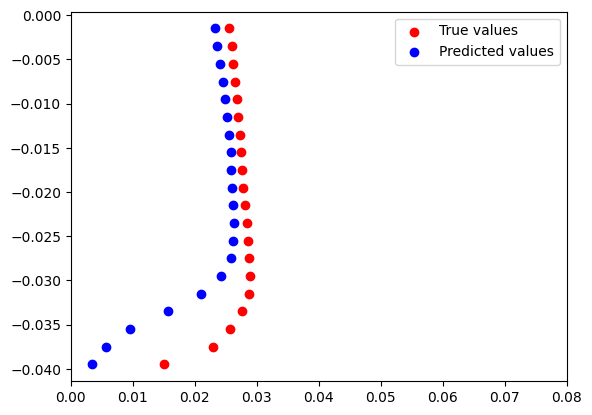

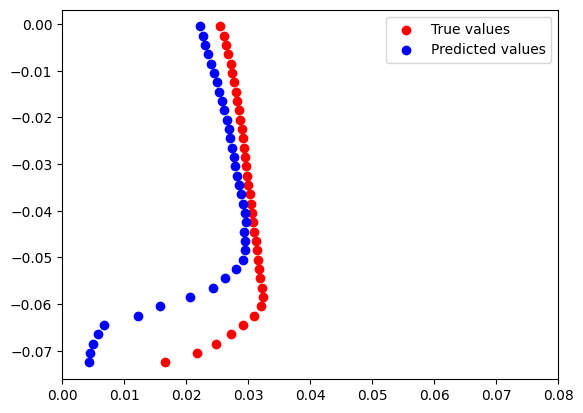

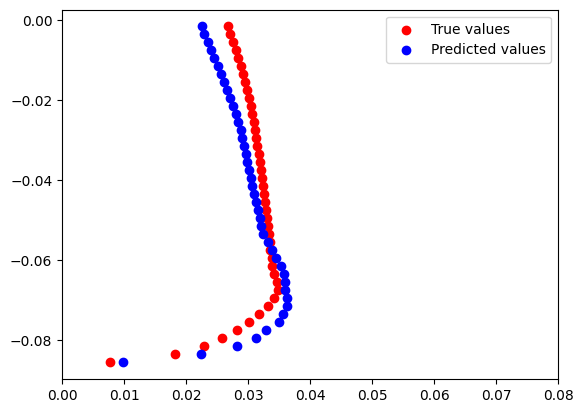

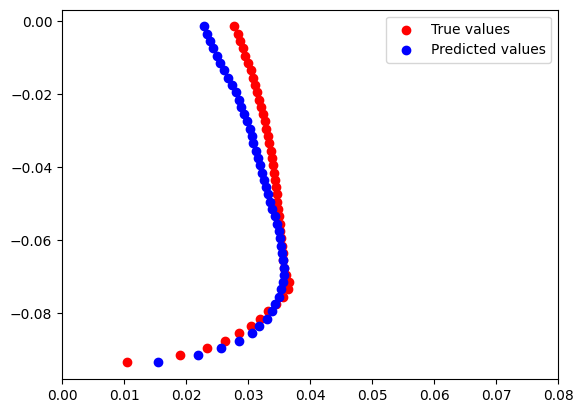

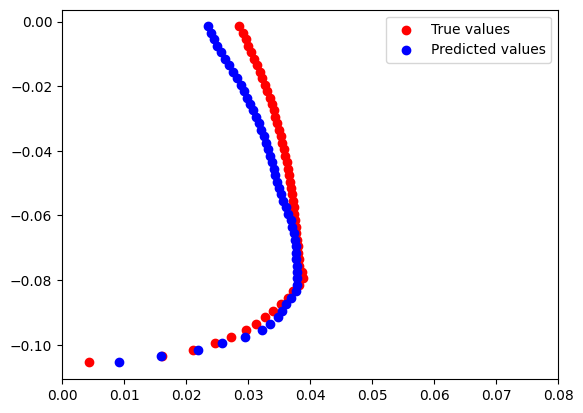

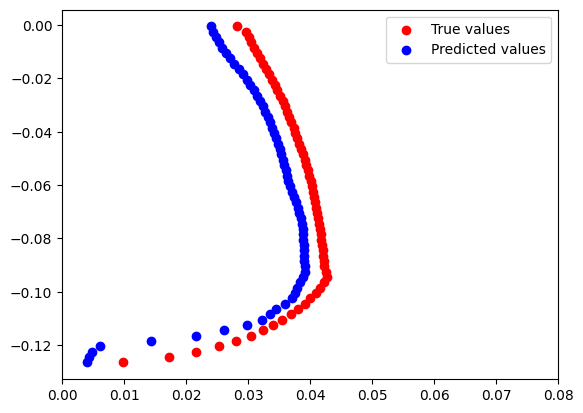

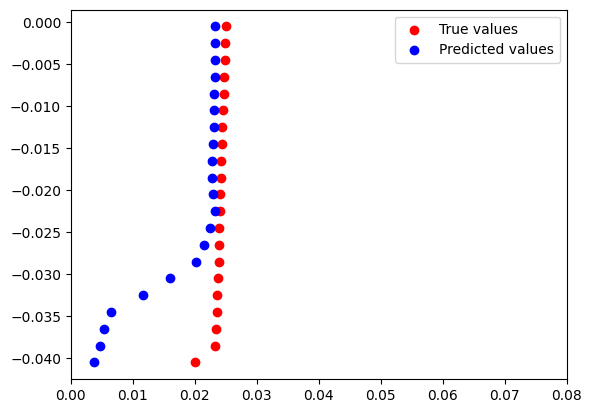

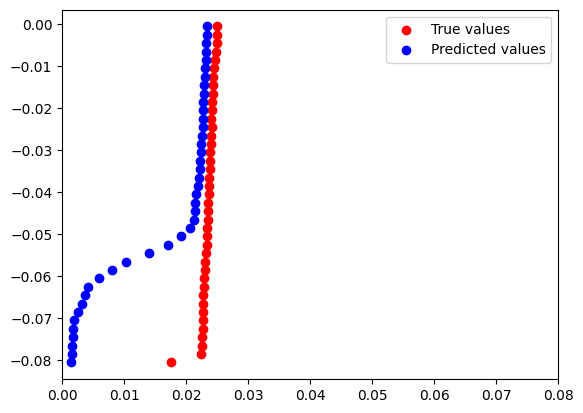

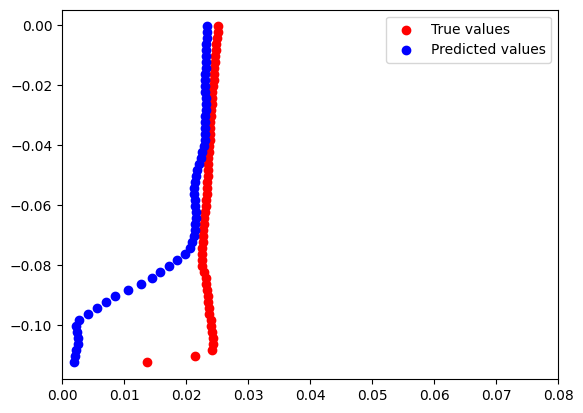

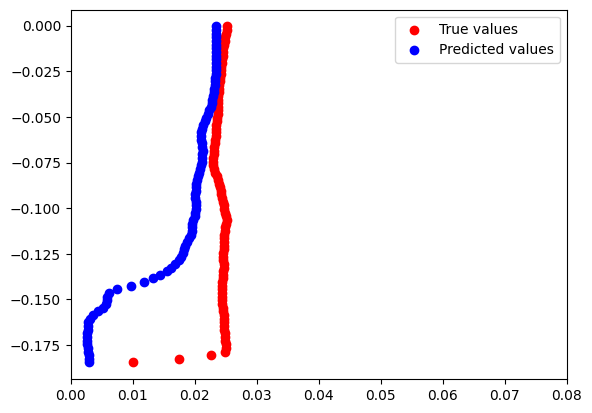

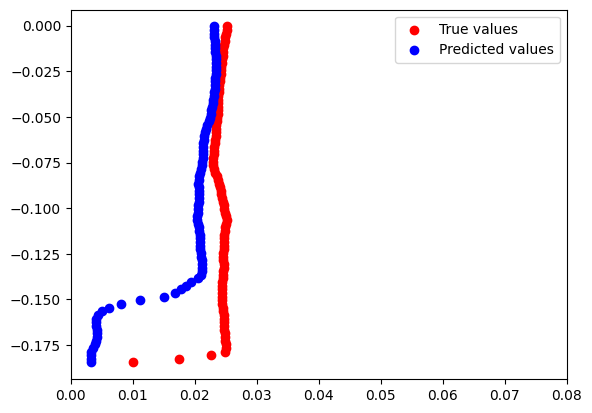

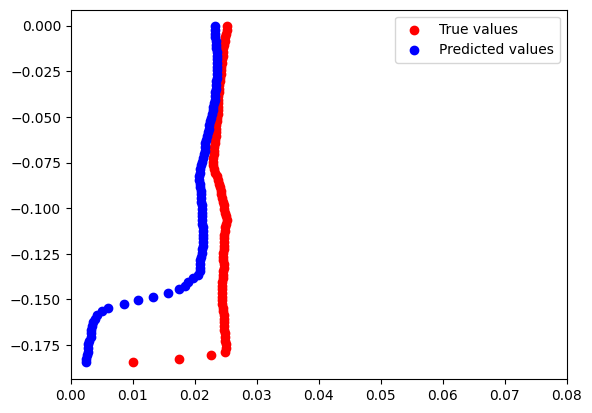

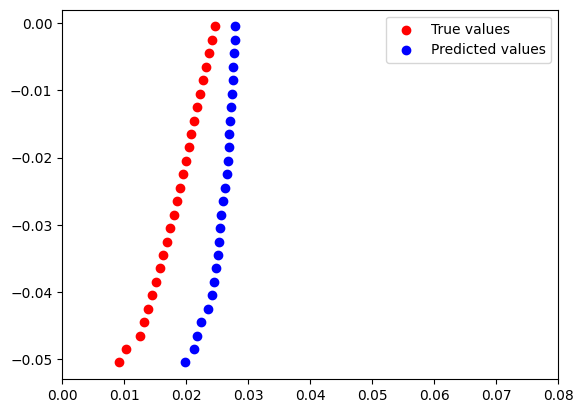

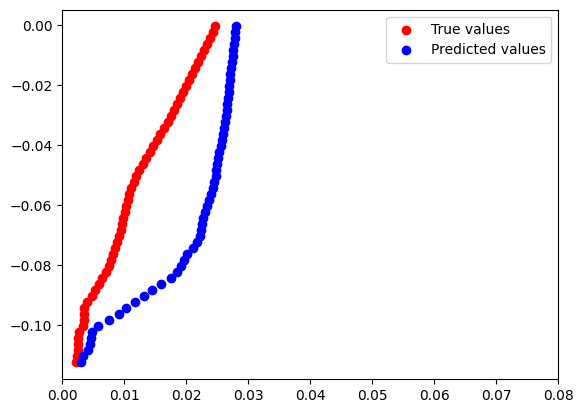

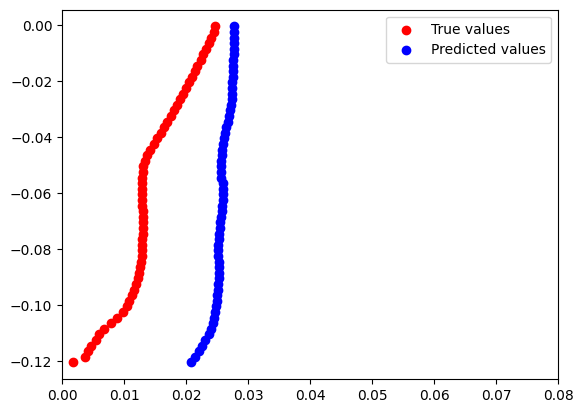

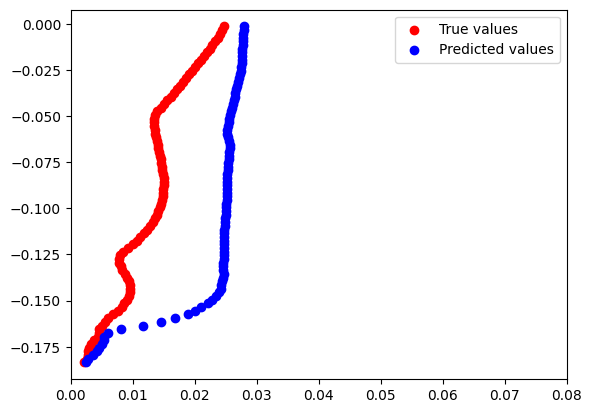

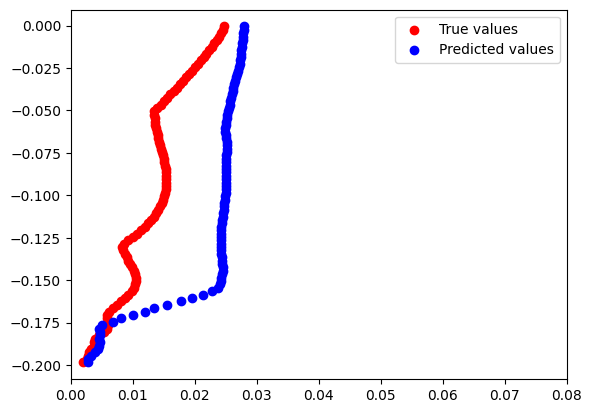

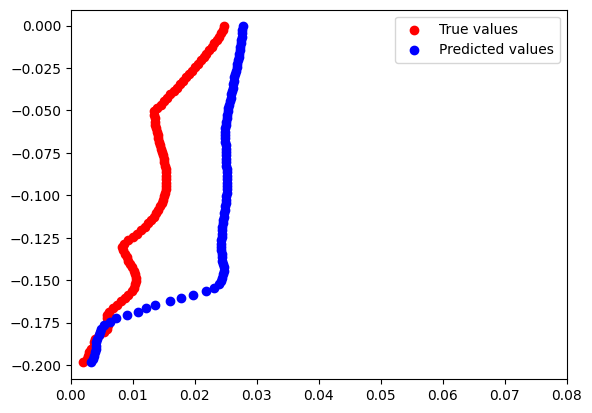

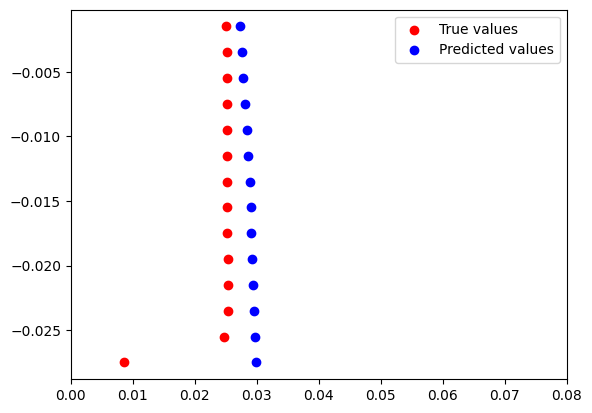

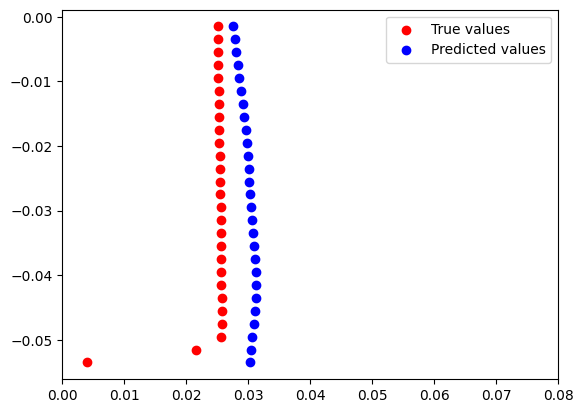

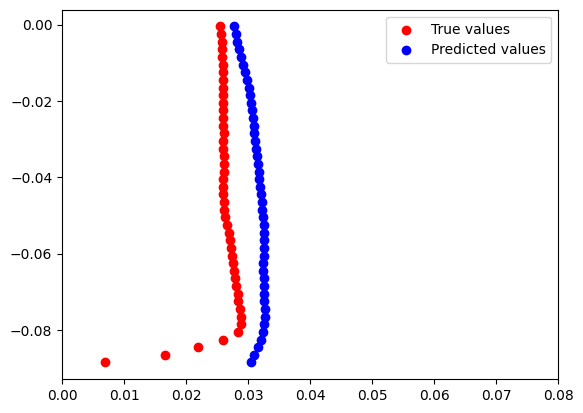

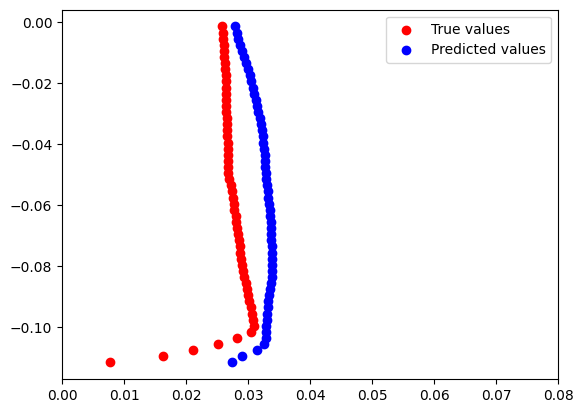

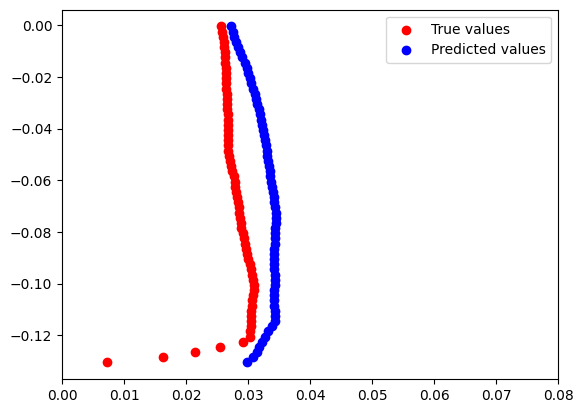

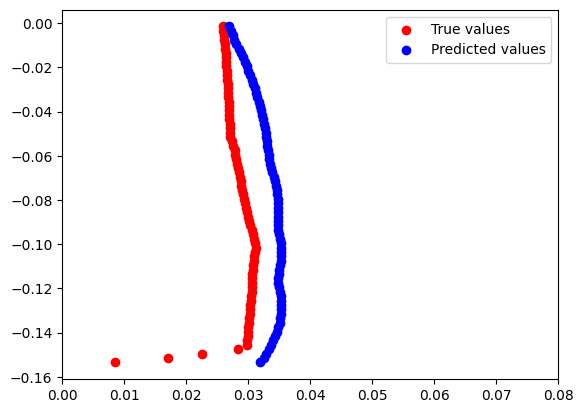

In [57]:
index = 0
count = 1
for i in indexes:
    plt.figure()
    plt.xlim(0,0.08)
    plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
    plt.scatter(y_pred[index:i,0]/100000000, X_test_plot[index:i,0],c='blue',label=f'Predicted values')
    plt.legend()
    plt.show()
    index = i
    if count==24: break
    count+=1

In [ ]:
plt.scatter(y_test.iloc[:,0],x_test.iloc[:,0], c='red',label=f'True values')
plt.scatter(predictions[:,0], X_test_plot[:,0],c='blue',label=f'Predicted values')
plt.legend()  
plt.show()

CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape))
    # model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=31, kernel_size=1, activation='relu'))
    
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    
    # Flatten before feeding into LSTM
    model.add(tf.keras.layers.Reshape((1, 31)))
    model.add(LSTM(200, dropout=0.3, return_sequences=True, activation='relu'))
    # model.add(LSTM(100, dropout=0.4, return_sequences=True, activation='relu'))
    model.add(LSTM(50, activation='relu'))
    # model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(Dense(1))  # Assuming 1 target variable
    model.compile(optimizer='adam', loss='mae')
    return model


In [ ]:
# Build and train the model
cnn_model = create_cnn_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1],X_train_scaled_reshaped.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1)
history = cnn_model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=100, batch_size=16, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr), callbacks=[early_stopping])

# val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# print(f'Validation Loss: {val_loss}')

# Predict on the test set
y_pred = cnn_model.predict(X_test_scaled_reshaped)

In [ ]:
predictions = scaler_y_test.inverse_transform(y_pred)
X_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],31))
# test_df_final['predictions'] = predictions

In [ ]:
plt.figure(figsize=(10,6))
plt.xlim(0,0.08)
#for t=2 and first param values
plt.scatter(y_test.iloc[20:57],X_test_plot[20:57,0],c='red',label=f'True values')
# plt.scatter(y_test.iloc[:20],X_test_plot[:20,0],c='red',label=f'True values')
plt.scatter(predictions[20:57],X_test_plot[20:57,0],c='blue',label=f'Predicted values')
# plt.scatter(predictions[:20],X_test_plot[:20,0],c='blue',label=f'Predicted values')
plt.legend()

New LSTM

In [ ]:
df_final

In [ ]:
new_x_train = df_final[['Z','time', 'Arflux1','Arflux2','Arflux3','Arflux4','Arflux5','Arflux6',
            'Fflux1','Fflux2','Fflux3','Fflux4','Fflux5','Fflux6',
            'ArExponent','FrExponent', 'predictions']]
new_y_train = df_final[['avg fitradius']]
new_y_test = test_df_final[['avg fitradius']]
new_x_test = test_df_final[['Z','time','Arflux1','Arflux2','Arflux3','Arflux4','Arflux5','Arflux6',
            'Fflux1','Fflux2','Fflux3','Fflux4','Fflux5','Fflux6',
            'ArExponent','FrExponent', 'predictions']]

In [ ]:
new_x_test.head(20)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
new_X_scale_arr = scaler_x_train.fit_transform(new_x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)

scaler_y_train = StandardScaler()
new_y_scale_arr = scaler_y_train.fit_transform(new_y_train)
df_scaledy = pd.DataFrame(y_scale_arr, columns=y_train.columns)

scaler_x_test = StandardScaler()
new_X_scale_t_arr = scaler_x_test.fit_transform(new_x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

scaler_y_test = StandardScaler()
new_y_scale_t_arr = scaler_y_test.fit_transform(new_y_test)
df_scaledy_t = pd.DataFrame(y_scale_t_arr, columns=y_test.columns)


new_X_train_scaled_reshaped = new_X_scale_arr.reshape(new_X_scale_arr.shape[0],1,new_X_scale_arr.shape[1])
new_X_train_scaled_reshaped.shape

new_X_test_scaled_reshaped = new_X_scale_t_arr.reshape(new_X_scale_t_arr.shape[0],1,new_X_scale_t_arr.shape[1])
new_X_test_scaled_reshaped.shape

In [ ]:
lstm_model_1.save_weights('initial_model_weights.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.layers import Attention, Dropout, GlobalAveragePooling1D

from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dropout
from keras.regularizers import l1, l2

def create_lstm_model(input_shape):

    lstm_input = Input(shape=input_shape)
    x = LSTM(200, dropout = 0.5, return_sequences=True, activation='relu')(lstm_input)
    # x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    # x = GlobalAveragePooling1D()(x)
    x = Dense(100, activation='relu')(x)
    output = Dense(1)(x)  # Assuming 1 target variable
    model = Model(inputs = lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='mae')
    return model

   #  lstm_input = Input(shape=input_shape)
   #  x = LSTM(200, dropout=0.4, return_sequences=True, activation='relu')(lstm_input)
   #  lstm_out = LSTM(128, dropout=0.3, return_sequences=True, activation='relu')(x)
   #  attention = Attention()([lstm_out, lstm_out])
   #  context = GlobalAveragePooling1D()(attention)
   #  output = Dense(1)(context)  # Assuming 1 target variable
   #  model = Model(inputs=lstm_input, outputs=output)
   #  model.compile(optimizer='adam', loss='mae')
   #  return model
   #  return model

In [ ]:
# Build and train the model
model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
model.load_weights('initial_model_weights.h5', by_name=True, skip_mismatch=True)
history = model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=100, batch_size=128, verbose=1 , validation_data=[X_test_scaled_reshaped, y_scale_t_arr])

# val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# print(f'Validation Loss: {val_loss}')

# Predict on the test set
new_y_pred = model.predict(X_test_scaled_reshaped)

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score

def custom_mse(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def custom_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# mse_scorer = make_scorer(custom_mse, greater_is_better=False)
# r2_scorer = make_scorer(custom_r2)

# Evaluate the model
mae = custom_mse(new_y_scale_t_arr,new_y_pred)
r2_score = custom_r2(new_y_scale_t_arr, new_y_pred)

print("Mean Abs Error (MAE):", mae)
print("R2 score: ", r2_score)

In [ ]:
predictions = scaler_y_test.inverse_transform(new_y_pred)
X_test_plot = scaler_x_test.inverse_transform(new_X_test_scaled_reshaped.reshape(new_X_test_scaled_reshaped.shape[0],17))

In [ ]:
plt.figure(figsize=(10,6))
plt.xlim(0,.05)
#for t=2 and first param values
plt.scatter(y_test.iloc[:20],X_test_plot[:20,0],c='red',label=f'True values')
# plt.plot(y_test.iloc[:20],X_test_plot[:20,0],'r--')
plt.scatter(predictions[:20],X_test_plot[:20,0],c='blue',label=f'Predicted values')
# plt.plot(predictions[:20],X_test_plot[:20,0],'b--')
plt.legend()

GNN

In [ ]:
# import numpy as np
# import tensorflow as tf
# from spektral.data import Dataset, Graph
# from spektral.layers import GCNConv, GlobalAvgPool, GlobalMaxPool, GlobalAttentionPool, GlobalAttnSumPool
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense

# # Assuming X_train_scaled_reshaped, X_test_scaled_reshaped, y_scale_arr, and y_test are available and formatted as required

# # Sample data preparation
# num_nodes = X_train_scaled_reshaped.shape[1]
# num_features = X_train_scaled_reshaped.shape[2]
# num_classes = y_scale_arr.shape[1]

# # Generate adjacency matrix (modify to reflect your actual graph structure)
# # This is a simple example, consider using a sparse matrix for larger graphs
# #so using zeroes instead of ones
# A = np.zeros((num_nodes, num_nodes)) + np.eye(num_nodes)

# # Define a custom Spektral dataset
# class MyDataset(Dataset):
#     def __init__(self, X, A, y, **kwargs):
#         self.X = X
#         self.A = A
#         self.y = y
#         super().__init__(**kwargs)

#     def read(self):
#         graphs = []
#         for i in range(len(self.X)):
#             x = self.X[i]
#             a = self.A
#             y = self.y[i]
#             graphs.append(Graph(x=x, a=a, y=y))
#         return graphs

# # Create datasets
# train_dataset = MyDataset(X_train_scaled_reshaped, A, y_scale_arr)
# test_dataset = MyDataset(X_test_scaled_reshaped, A, y_scale_t_arr)

# # Define the GNN model using Spektral
# def create_gnn_model(input_shape, output_shape):
#     X_in = Input(shape=input_shape, name='node_features')
#     A_in = Input(shape=(num_nodes,), sparse=True, name='adjacency_matrix')

#     # Graph Convolutional Layer
#     x = GCNConv(100)([X_in, A_in])
#     x = GlobalAttnSumPool()(x)

#     # Fully connected layers
#     x = Dense(56)(x)
#     outputs = Dense(output_shape)(x)

#     return Model(inputs=[X_in, A_in], outputs=outputs)

# # Create and compile the model
# input_shape = (num_nodes, num_features)
# output_shape = y_scale_arr.shape[1]
# model = create_gnn_model(input_shape, output_shape)
# model.compile(optimizer='adam', loss='mae')

# # Convert the dataset to TensorFlow data format
# def dataset_to_tfdata(dataset):
#     def generator():
#         for graph in dataset:
#             yield (graph.x, graph.a), graph.y
#     return tf.data.Dataset.from_generator(
#         generator,
#         output_signature=(
#             (tf.TensorSpec(shape=(num_nodes, num_features), dtype=tf.float32),
#              tf.TensorSpec(shape=(num_nodes, num_nodes), dtype=tf.float32)),
#             tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
#         )
#     )

# # Create TensorFlow datasets
# train_tfdata = dataset_to_tfdata(train_dataset).batch(8)
# test_tfdata = dataset_to_tfdata(test_dataset).batch(8)

# # Train the model
# model.fit(train_tfdata, epochs=50)

# # Evaluate the model
# loss = model.evaluate(test_tfdata)
# print(f"Test Loss: {loss}")

# # Predict on the test set
# y_pred = model.predict(test_tfdata)


In [ ]:
# loss = model.evaluate(test_tfdata)
# print(f"Test Loss: {loss}")

# # Predict on the test set
# y_pred = model.predict(test_tfdata)

In [ ]:
# predictions = scaler_y_test.inverse_transform(y_pred)

In [ ]:
# plt.scatter(y_test.iloc[:],X_test_plot[:,0],c='red',label=f'True values')
# # plt.plot(y_test.iloc[20:55],X_test_plot[20:55,0],'r--')
# plt.scatter(predictions[:],X_test_plot[:,0],c='blue',label=f'Predicted values')
# # plt.plot(predictions[20:55],X_test_plot[20:55,0],'b--')
# plt.legend()